In [1]:
import os, h5py
os.environ['CUDA_VISIBLE_DEVICES']='1'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logomaker
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from tqdm import tqdm

from cremerl import utils, model_zoo, shuffle

import shuffle_test

#import gymnasium as gym

import logging

# Set the logging level to WARNING
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

In [2]:
expt_name = 'DeepSTARR'

# load data
data_path = '../../data/'
filepath = os.path.join(data_path, expt_name+'_data.h5')
data_module = utils.H5DataModule(filepath, batch_size=100, lower_case=False, transpose=False)


In [3]:
deepstarr2 = model_zoo.deepstarr(2)
loss = torch.nn.MSELoss()
optimizer_dict = utils.configure_optimizer(deepstarr2, lr=0.001, weight_decay=1e-6, decay_factor=0.1, patience=5, monitor='val_loss')
standard_cnn = model_zoo.DeepSTARR(deepstarr2,
                                  criterion=loss,
                                  optimizer=optimizer_dict)

# load checkpoint for model with best validation performance
standard_cnn = utils.load_model_from_checkpoint(standard_cnn, 'DeepSTARR_standard.ckpt')

# evaluate best model
pred = utils.get_predictions(standard_cnn, data_module.x_test[np.newaxis,100], batch_size=100)

/home/yiyu/.conda/envs/tf_2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
2023-08-15 10:23:14.003320: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 10:23:14.525062: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/yiyu/.conda/envs/tf_2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_

Predicting: 0it [00:00, ?it/s]

In [4]:
def get_batch(x, tile_ranges, trials):
    test_batch = []
    for i in range(trials):
        test_batch.append(x)
        x_mut = (shuffle_test.dinuc_shuffle(x.copy().transpose())).transpose()
        test_batch.append(x_mut)

        for tile_range in tile_ranges:
            ori = x.copy()
            ori[:, tile_range[0]:tile_range[1]] = x_mut[:, tile_range[0]:tile_range[1]]
            test_batch.append(ori)

            mut = x_mut.copy()
            mut[:, tile_range[0]:tile_range[1]] = x[:, tile_range[0]:tile_range[1]]
            test_batch.append(mut)

    #print(np.array(test_batch).shape)
    return np.array(test_batch)


def find_max(pred, trials):
    b_size = int(pred.shape[0]/trials)
    loop_range = generate_tile_ranges(pred.shape[0], b_size, b_size)
    total_score = []
    total_score_sep = []
    for rang in loop_range:
        score = []
        score_sep = []
        p_pred = pred[rang[0]:rang[1]]
        for i in range(0, p_pred.shape[0]-2, 2):
            score1 = p_pred[0] - p_pred[i]
            score2 = p_pred[i+1] - p_pred[1]
            score.append((np.sum((score1, score2)[0])).tolist()) #np.sum(score1+score2, keepdims=True)
            score_sep.append((score1+score2).tolist())

        #print(score)

        total_score.append(score)
        total_score_sep.append(score_sep)

    final = np.sum(np.array(total_score), axis=0)/trials

    max_ind = np.argmax(final)
    block_ind = np.argmax(np.array(total_score)[:, max_ind])
    #print(np.array(total_score)[:, max_ind])

    total_score = final
    total_score_sep = np.sum(np.array(total_score_sep), axis=0)/trials


    #print(np.max(score))
    return np.max(total_score), np.argmax(total_score), block_ind


def get_swap_greedy(x, x_mut, tile_ranges):
    ori = x.copy()
    mut = x_mut.copy()
    for tile_range in tile_ranges:
        ori[:, tile_range[0]:tile_range[1]] = x_mut[:, tile_range[0]:tile_range[1]]
        mut[:, tile_range[0]:tile_range[1]] = x[:, tile_range[0]:tile_range[1]]

    return ori, mut

def get_score(pred):
    score1 = pred[0] - pred[2]
    score2 = pred[3] - pred[1]
    return (score1+score2)[0], score1+score2

def generate_tile_ranges(sequence_length, window_size, stride):
    ranges = []
    start = np.arange(0, sequence_length - window_size + stride, stride)

    for s in start:
        e = min(s + window_size, sequence_length)
        ranges.append([s, e])

    if start[-1] + window_size - stride < sequence_length:  # Adjust the last range
        ranges[-1][1] = sequence_length

    return ranges

In [5]:
def find_max(pred, trials):
    b_size = int(pred.shape[0]/trials)
    loop_range = generate_tile_ranges(pred.shape[0], b_size, b_size)
    total_score = []
    total_score_sep = []
    for rang in loop_range:
        score = []
        score_sep = []
        p_pred = pred[rang[0]:rang[1]]
        for i in range(0, p_pred.shape[0]-2, 2):
            score1 = p_pred[0] - p_pred[i]
            score2 = p_pred[i+1] - p_pred[1]
            score.append((np.sum((score1, score2)[0])).tolist()) #np.sum(score1+score2, keepdims=True)
            score_sep.append((score1+score2).tolist())

        #print(score)

        total_score.append(score)
        total_score_sep.append(score_sep)

    final = np.sum(np.array(total_score), axis=0)/trials

    max_ind = np.argmax(final)
    block_ind = np.argmax(np.array(total_score)[:, max_ind])
    #print(np.array(total_score)[:, max_ind])

    total_score = final
    total_score_sep = np.sum(np.array(total_score_sep), axis=0)/trials


    #print(np.max(score))
    return total_score_sep, np.max(total_score), np.argmax(total_score), block_ind

In [8]:
trials = 1
test = []
for i in range(10):
    x = data_module.x_test[i].numpy()
    tile_ranges = generate_tile_ranges(x.shape[1], 5, 5)
    trainer = pl.Trainer(accelerator='gpu', devices='1', logger=None, enable_progress_bar=False)
    batch = get_batch(x, tile_ranges, trials=trials)
    #print(batch.shape)
    dataloader = torch.utils.data.DataLoader(batch, batch_size=100, shuffle=False)
    pred = np.concatenate(trainer.predict(standard_cnn, dataloaders=dataloader))
    #print(pred.shape)
    total_score, score, best, block_ind = find_max(pred, trials=trials)
    test.append(total_score)

In [6]:
trials = 200 # 1000
test2 = []
for i in range(10):
    x = data_module.x_test[i].numpy()
    tile_ranges = generate_tile_ranges(x.shape[1], 5, 5)
    trainer = pl.Trainer(accelerator='gpu', devices='1', logger=None, enable_progress_bar=False)
    batch = get_batch(x, tile_ranges, trials=trials)
    #print(batch.shape)
    dataloader = torch.utils.data.DataLoader(batch, batch_size=100, shuffle=False)
    pred = np.concatenate(trainer.predict(standard_cnn, dataloaders=dataloader))
    #print(pred.shape)
    total_score, score, best, block_ind = find_max(pred, trials=trials)
    test2.append(total_score)

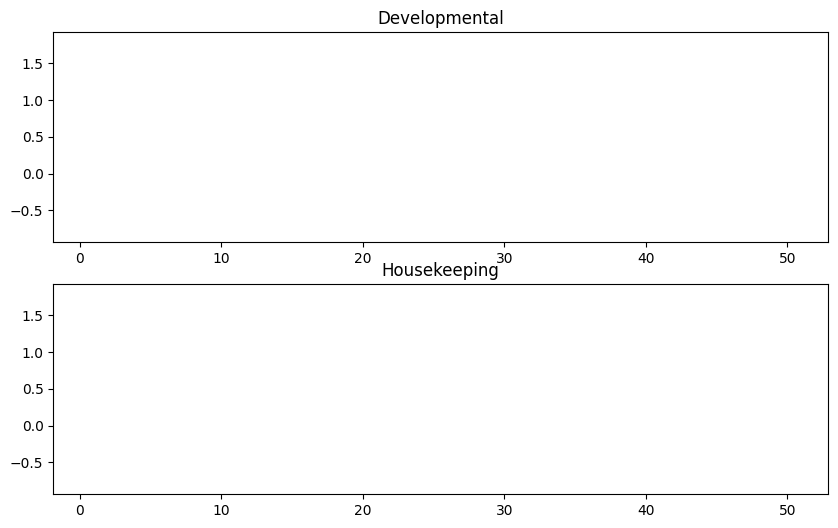

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharey=True)
x = np.arange(1, 51)

artists = []
for i, j in zip(test, test2):  # Pair each element of 'test' with the corresponding element of 'test2'
    container1 = ax1.bar(x, j[:, 0], color="orange")
    container2 = ax2.bar(x, j[:, 1], color="blue")
    artists.append(container1 + container2)  # Combine the artists for both subplots in one list

ax1.set_title("Developmental")
ax2.set_title("Housekeeping")

comp = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
comp

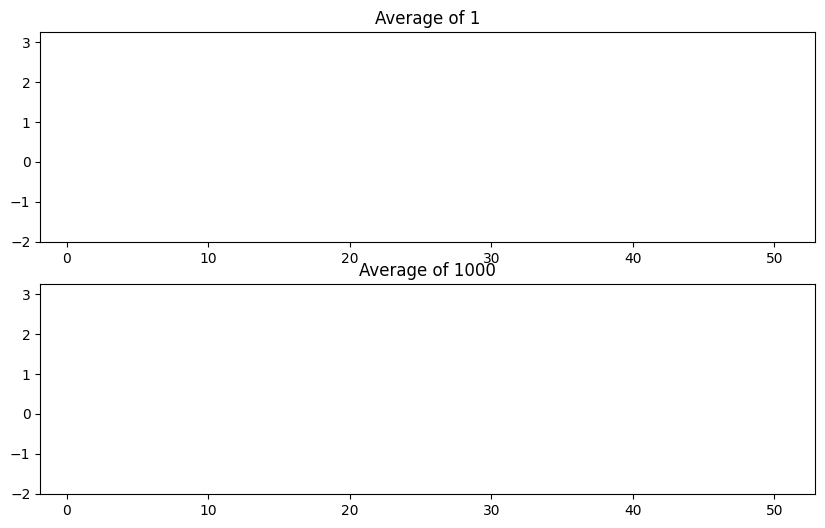

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharey=True)
x = np.arange(1, 51)

artists = []
for i, j in zip(test, test2):  # Pair each element of 'test' with the corresponding element of 'test2'
    container1 = ax1.bar(x, i[:, 0], color="orange")
    container2 = ax2.bar(x, j[:, 0], color="blue")
    artists.append(container1 + container2)  # Combine the artists for both subplots in one list

ax1.set_title("Average of 1")
ax2.set_title("Average of 1000")

comp = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
comp


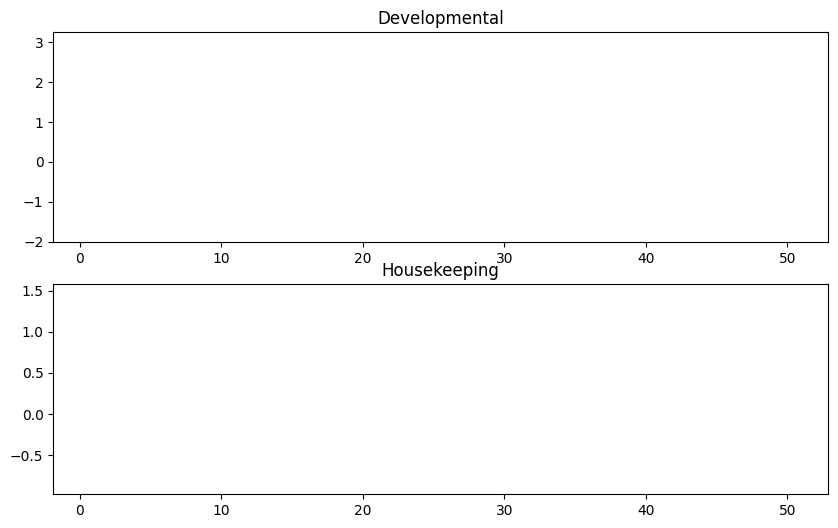

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
x = np.arange(1, 51)

artists = []
for i in test:
    container1 = ax1.bar(x, i[:, 0], color="orange")
    container2 = ax2.bar(x, i[:, 1], color="blue")
    artists.append(container1 + container2)  # Combine the artists for both subplots in one list

ax1.set_title("Developmental")
ax2.set_title("Housekeeping")

comp = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
comp


In [12]:
trials = 10
test = []
for i in range(50):
    x = data_module.x_test[3].numpy()
    tile_ranges = generate_tile_ranges(x.shape[1], 5, 5)
    trainer = pl.Trainer(accelerator='gpu', devices='1', logger=None, enable_progress_bar=False)
    batch = get_batch(x, tile_ranges, trials=trials)
    #print(batch.shape)
    dataloader = torch.utils.data.DataLoader(batch, batch_size=100, shuffle=False)
    pred = np.concatenate(trainer.predict(standard_cnn, dataloaders=dataloader))
    #print(pred.shape)
    total_score, score, best, block_ind = find_max(pred, trials=trials)
    test.append(total_score)

/home/yiyu/.conda/envs/tf_2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


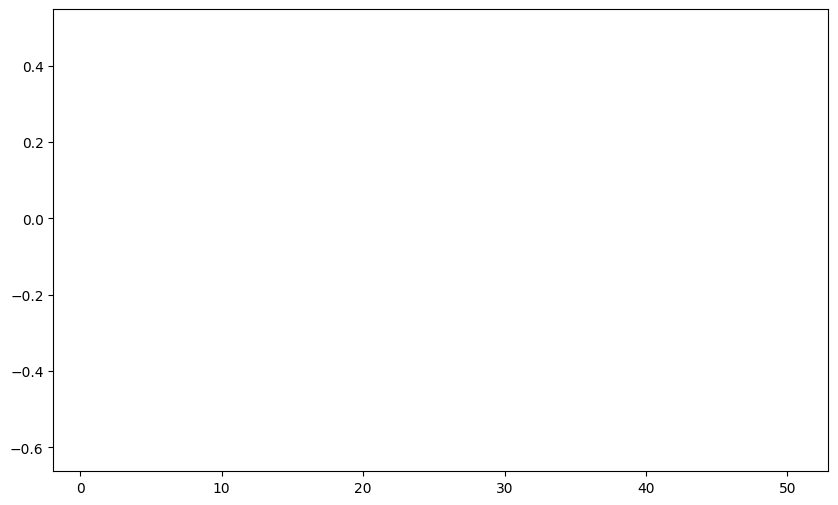

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(1, 51)

artists = []
for i in test:
    container = ax.bar(x, i[:,1], color="blue")
    artists.append(container)

ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
#plt.show()
ani

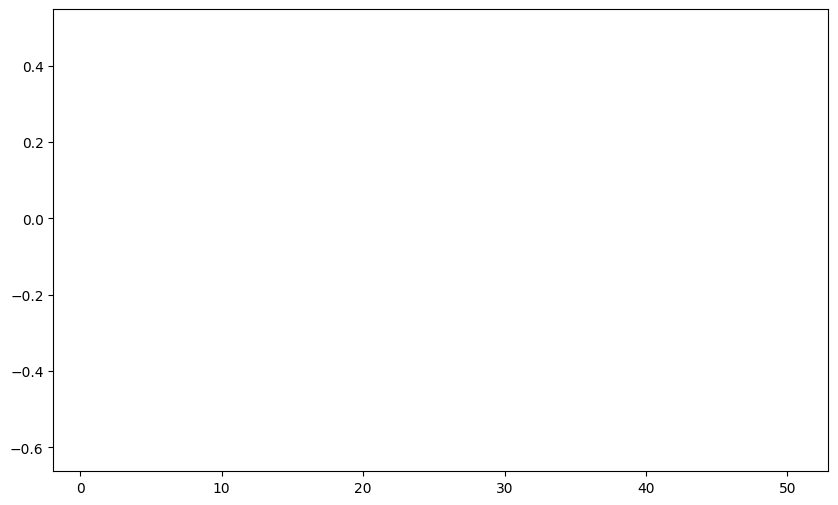

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(1, 51)

artists = []
for i in test:
    container = ax.bar(x, i[:,1], color="blue")
    artists.append(container)

ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
#plt.show()
ani

In [15]:
def plot_bar_graph(data_array):
    x = np.arange(1, 51)  # X-axis values (from 1 to 50)
    y = data_array        # Y-axis values

    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.bar(x, y)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Bar Graph')
    plt.show()

In [ ]:
plot_bar_graph(total_score)